# CS 598 Deep Learning for Health Care Project - Team 72</h1>
 * Timothy Ta (ta14@illinois.edu)
 * Ariel Chiang (arieltc2@illinois.edu)
 * Jingtian Yao (yao28@illinois.edu)

#### **Github Repo:** https://github.com/lanceyjt/cs598-dlh-team72

In [1]:
import sys

COLAB = 'google.colab' in sys.modules
SAGEMAKER = not COLAB
LOAD_PRETRAIN_MODEL = True
LOAD_FINAL_MODEL = True # Set False for training

In [2]:
if COLAB:
    from google.colab import drive
    drive.mount('/content/drive/')
    ROOT_PATH = '/content/drive/MyDrive/CS598-DLH-Team72/code'
if SAGEMAKER:
    ROOT_PATH = '/home/ec2-user/SageMaker/cs598-dlh-team72/code'

In [3]:
!pip install subword_nmt

In [4]:
!pip install funcsigs

# Introduction
In the world of medicine, patients are often prescribed multiple drugs in which some sets have drug-drug interactions (DDIs). These DDIs can cause morbidity and mortality. As part of drug design and safety, researchers look to identify these interactions through computational models. However, Huang et al. (2020) point out that there are three limitations to current predictive models and propose a ChemicAl SubstrcTurE Representation (CASTER) framework to mitigate these limitations.

<h3>The CASTER Model</h3>

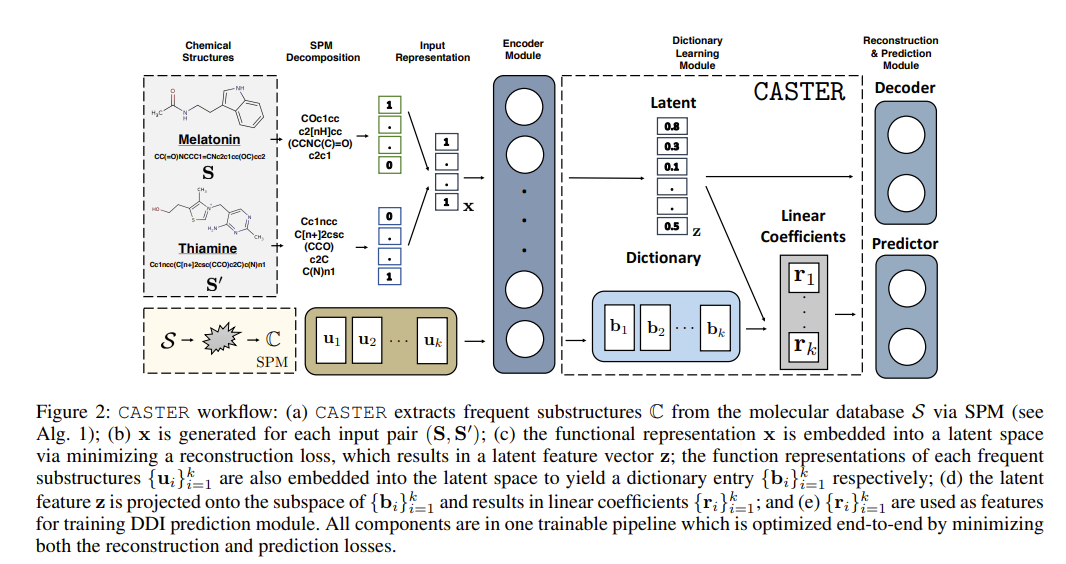

(Huang et al., 2020, p. 3)

<h4>First Limitation</h4>

Huang et al. (2020) highlight that there is no specialized representation for drugs used in DDI prediction.
Current predictive models use the entire chemical representation as an input. Typically, chemicals are represented as SMILE strings depicted below:
<br>
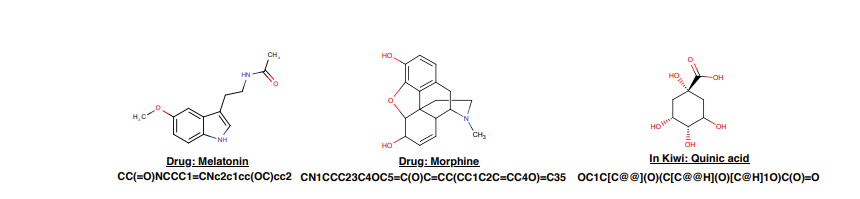
<br>
(Huang et al., 2020, p. 2)

Previous research has used these representations directly. CASTER, on the other hand, uses frequent pattern mining to extract out frequent substructures of chemicals before encoding them into a latent space. In DDIs, what is often important is that a substructure of one drug interacts with another substructure. Finding a representation for these substructures may reduce the bias towards irrelevant parts of the chemical.


<h4>Second Limitation</h4>
The second limitation is the reliance on labeled training data. This reliance reduces the generalizability of the model against new drugs being developed. CASTER combats this by using an autoencoder that is not reliant on labeled data.

<h4>Third Limitation</h4>
Lastly, many machine learning models' predictions are often uninterpretable. CASTER offers interpretable results by associating linear coefficients with a dictionary of chemical substructures. These linear coefficients allow humans to understand the contribution of each substructure to the prediction.

# Scope of Reproducibility

This project intends to reproduce the ChemicAl SubstrcTurE Representation (CASTER) framework using the provided dataset and leveraging existing code of the original paper. Using these results we look to verify the claims made by Huang et. al (2020).

Hypothesis 1: CASTER provides more accurate DDI prediction compared to other contemporary models<br>
&emsp;These models include Linear Regression, Nat.Prot (Vilar et al. 2014), Mol2Vec (Jaeger, Fulle, and Turk 2018),<br>
&emsp;MolVAE (Gomez-Bombvarelli et al. 2018), and DeepDDI (Ryu, Kim, and Lee 2018).<br>

Hypothesis 2: CASTER improves the generalizability of DDI predictions by using unlabelled data<br>

Hypothesis 3: CASTER's dictionary module allows for an intuitive interpretation of chemical substructure's contributions to the prediction results<br>



# Methodology

To reproduce CASTER we first explore the data and then create a model. From this model, we will generate results to compare and test against our hypotheses

First, we import all of our vairous models and packages. Primarily we are using PyTorch to create the model and other packages to visualize our results

In [5]:
default_sys_path = sys.path.copy()

# Add helper code to system path
sys.path.append(ROOT_PATH + '/CASTER/DDE/')

In [6]:
# Import modules
import os
import torch
import copy
import warnings
import json
import numpy as np
import pandas as pd
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.autograd import Variable
from torch.utils import data
import torch.utils.data as Data
from torch import nn
from tqdm import tqdm
from time import time
from sklearn.metrics import roc_auc_score, precision_recall_curve, \
        average_precision_score, roc_curve, auc, confusion_matrix, \
        classification_report, f1_score
from sklearn.model_selection import KFold
#from dde_config import dde_NN_config
#from dde_torch import dde_NN_Large_Predictor
from stream_dde import supData, unsupData, supData_index
from funcsigs import signature
from datetime import datetime
from __future__ import print_function


torch.manual_seed(2)    # reproducible torch:2 np:3
np.random.seed(3)
warnings.simplefilter("ignore")
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
plt.style.use('bmh')

## Environment

This Jupyter notebook is executed in Python version 3.10.14, packaged by conda-forge.

All dependenceis can be found in the code section below, or refer to "**requirements.txt**" in the Github repo. The **requirements.txt** file is created by the command below in Sagemaker instance.
```
pip freeze > requirements.txt
```

### Python Version

In [7]:
print("Python Version:")
print(sys.version)

Python Version:
3.10.14 | packaged by conda-forge | (main, Mar 20 2024, 12:45:18) [GCC 12.3.0]


### Dependencies

In [8]:
with open('./requirements.txt', "r") as file:
    for line in file:
        if "@" not in line:
            print(line.strip())

aiofiles==22.1.0
aiosqlite==0.20.0
astroid==3.1.0
autopep8==2.0.4
awscli==1.32.89
Babel==2.14.0
backcall==0.2.0
boto3==1.34.89
botocore==1.34.89
cloudpickle==2.2.1
colorama==0.4.4
contextlib2==21.6.0
dill==0.3.8
docker==6.1.3
docopt==0.6.2
docstring-to-markdown==0.15
docutils==0.16
environment-kernels==1.2.0
gitdb==4.0.11
GitPython==3.1.43
google-pasta==0.2.0
gssapi==1.8.3
importlib-metadata==6.11.0
ipykernel==5.5.6
ipython==8.12.3
ipython-genutils==0.2.0
isort==5.13.2
json5==0.9.25
jupyter-lsp==2.2.5
jupyter-server-mathjax==0.2.6
jupyter-ydoc==0.2.5
jupyter_client==7.4.9
jupyter_server_fileid==0.9.2
jupyter_server_ydoc==0.8.0
jupyterlab==3.6.7
jupyterlab-git==0.41.0
jupyterlab-lsp==4.3.0
jupyterlab_server==2.27.1
krb5==0.5.1
mccabe==0.7.0
multiprocess==0.70.16
nbconvert==7.16.3
nbdime==3.2.1
pandas==1.5.3
pathos==0.3.2
pid==3.0.4
pipreqs==0.5.0
pluggy==1.5.0
pox==0.3.4
ppft==1.7.6.8
protobuf==4.25.3
py4j==0.10.9.5
pyasn1==0.6.0
pycodestyle==2.11.1
pydocstyle==6.3.0
pyflakes==3.2.0
pyg

## Data

There are two datasets used by CASTER.

The first one being DrugBank (Wishart et al. 2008). The dataset contains 10974 unique drugs. This dataset is split up into training and testing subsets. The training data comprising of 10951 unique drugs with 33243 DDI and 33189 non-DDI. While the testing data contains 9137 unique drugs with 8311 DDI and 8277 non-DDI.

The second dataset is BioSNAP (Marinka Zitnik and Leskovec 2018) which consists of drug-drug and drug-food pairs.

Data is saved into this github repo and original sources linked below. You can find data in the path in repo ```ROOT_PATH + '/CASTER/DDE/data'```, no extra step is required to download the data.

**Drugbank**
[Wishart et al. 2008] Wishart, D. S.; Knox, C.; Guo, A.;
Cheng, D.; Shrivastava, S.; Tzur, D.; Gautam, B.; and Hassanali, M. 2008. Drugbank: a knowledgebase for drugs, drug
actions and drug targets. Nucleic Acids Research 36:901–
906

**BioSNAP**
[Marinka Zitnik and Leskovec 2018] Marinka Zitnik,
Rok Sosic, S. M., and Leskovec, J. 2018. BioSNAP ˇ
Datasets: Stanford biomedical network dataset collection.
http://snap.stanford.edu/biodata.

In [42]:
dataFolder = ROOT_PATH + '/CASTER/DDE/data'

In [43]:
# Load SMILES for a drug-drug or drug-food pair
df_unsup = pd.read_csv(dataFolder + '/unsup_dataset.csv', names = ['idx', 'input1_SMILES', 'input2_SMILES', 'type']).drop(0)
print("Number of rows:", df_unsup.shape[0])
df_unsup.head(5)

Number of rows: 441854


,idx,input1_SMILES,input2_SMILES,type
1,202274,CCCCCCCC/C=C\CCCCCCCC(=O)OC[C@H](COP(=O)(O)OCC...,CC(O)=N[C@@H]1[C@@H](O)C=C(C(=O)O)O[C@H]1[C@H]...,df_pair
2,381808,Cc1ncc2n1-c1ccc(Cl)cc1C(c1ccccc1F)=NC2,CNCCC(Oc1ccc(C(F)(F)F)cc1)c1ccccc1,dd_pair
3,372979,O=c1oc2ccccc2c(O)c1Cc1c(O)c2ccccc2oc1=O,C=C[C@H]1CN2CC[C@H]1C[C@@H]2[C@@H](O)c1ccnc2cc...,dd_pair
4,60778,COc1c(OC)c(O)c2c(=O)cc(-c3ccc(O)cc3)oc2c1OC,CCC1=C[C@@H]2CN(C1)Cc1c([nH]c3ccccc13)[C@@](C(...,df_pair
5,196908,COC(OC)C(C)c1ccccc1,CN(C)c1cccc2c(S(=O)(=O)O)cccc12,df_pair


In [44]:
# Load training dataset for drug-drug interaction
df_ddi = pd.read_csv(dataFolder + '/BIOSNAP/sup_train_val.csv')
df_ddi.drop(df_ddi.columns[0], axis=1, inplace=True)
print("Number of rows:", df_ddi.shape[0])
df_ddi.head(5)

Number of rows: 66432


,Drug1_ID,Drug1_SMILES,Drug2_ID,Drug2_SMILES,label
0,DB00706,CCOc1ccccc1OCCN[C@H](C)Cc1ccc(OC)c(S(N)(=O)=O)c1,DB01023,CCOC(=O)C1=C(C)NC(C)=C(C(=O)OC)C1c1cccc(Cl)c1Cl,1.0
1,3849.0,C[C@@H](Oc1ccc2[nH]nc(/C=C/c3cnn(CCO)c3)c2c1)c...,3515.0,COc1ccc2c(c1)c(CC(=O)O)c(C)n2C(=O)c1ccc(I)cc1,0.0
2,6380.0,O=P(O)(O)OCCCc1c[nH]c2ccccc12,8290.0,N[C@@H](c1ccccc1)c1ccc(-c2ncnc3[nH]cnc23)cc1,0.0
3,7947.0,CCCC(=O)O[C@]1(C(=O)COC(C)=O)CC[C@H]2[C@@H]3C[...,3010.0,CNCCc1ccccn1,0.0
4,DB00802,CCC(=O)N(c1ccccc1)C1(COC)CCN(CCn2nnn(CC)c2=O)CC1,DB00872,Cc1nc2c([nH]1)CCN(C(=O)c1ccc(NC(=O)c3ccccc3-c3...,1.0


In [45]:
# Load testing dataset for drug-drug interaction
df_ddi_test = pd.read_csv(dataFolder + '/BIOSNAP/sup_test.csv')
df_ddi_test.drop(df_ddi_test.columns[0], axis=1, inplace=True)
print("Number of rows:", df_ddi_test.shape[0])
df_ddi_test.head(5)

Number of rows: 16608


,Drug1_ID,Drug1_SMILES,Drug2_ID,Drug2_SMILES,label
0,8404.0,CC(O)=N[C@@H](Cc1cccc2ccccc12)[B-](O)(O)OC[C@H...,1503.0,CCc1ccc(NS(=O)(=O)O)cc1,0.0
1,DB00657,CNC1(C)C2CCC(C2)C1(C)C,DB05245,Nc1ccc(S(=O)(=O)[N-]c2ncccn2)cc1.[Ag+],1.0
2,8555.0,C[C@H]1C[C@@H](C)CN(C(=O)c2cc(Br)ccc2N)C1,2262.0,CCOc1cc(O[C@@H]2CCOC2)c(F)c([C@@H](Nc2ccc(C(=N...,0.0
3,3237.0,COc1cc2c(Nc3ccc(Br)cc3F)ncnc2cc1OCC1CCN(C)CC1,4032.0,C[C@](O)(COc1ccc(Cl)c(F)c1)C(=O)Nc1ccc(C#N)c(C...,0.0
4,DB01087,COc1cc(NC(C)CCCN)c2ncccc2c1,DB09065,CC(C)c1nc(CN(C)C(=O)N[C@@H](CCN2CCOCC2)C(=O)N[...,1.0


Unique drugs in training data:  10951
Label counts in training data:
 1.0    33243
0.0    33189
Name: label, dtype: int64


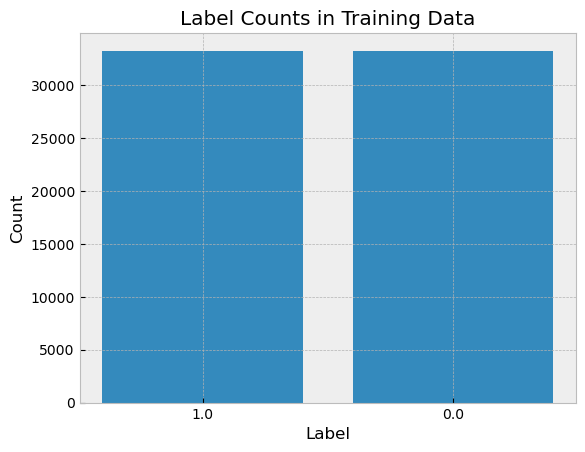

In [46]:
# Count the number of unique drugs
print("Unique drugs in training data: ", \
      len(pd.concat((df_ddi['Drug1_ID'], df_ddi['Drug2_ID'])).unique()))

# Count occurrences of each unique value in the "label" column
value_counts = df_ddi['label'].value_counts()

print("Label counts in training data:\n", value_counts)

# Plot the bar plot
plt.bar([str(x) for x in value_counts.keys()], value_counts.values)

# Title and labels
plt.title('Label Counts in Training Data')
plt.xlabel('Label')
plt.ylabel('Count')

# Show plot
plt.show()

Unique drugs in testing data:  9137
Unique drugs in training plus testing data:  10974
Label counts in testing data:
 0.0    8331
1.0    8277
Name: label, dtype: int64


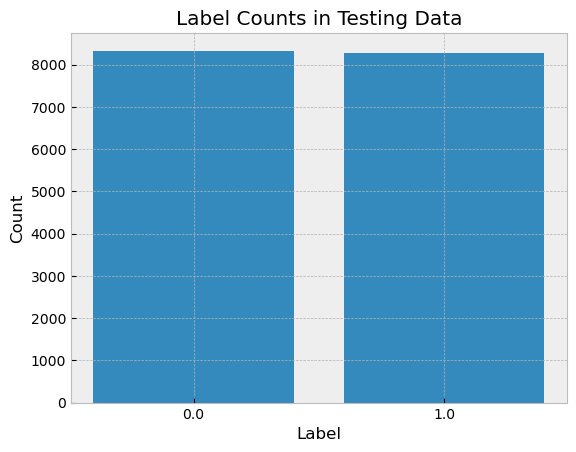

In [47]:
# Count the number of unique drugs
print("Unique drugs in testing data: ", \
      len(pd.concat((df_ddi_test['Drug1_ID'], df_ddi_test['Drug2_ID'])).unique()))
print("Unique drugs in training plus testing data: ", \
      len(pd.concat((df_ddi['Drug1_ID'], df_ddi['Drug2_ID'], \
                     df_ddi_test['Drug1_ID'], df_ddi_test['Drug2_ID'])).unique()))

# Count occurrences of each unique value in the "label" column
value_counts = df_ddi_test['label'].value_counts()

print("Label counts in testing data:\n", value_counts)

# Plot the bar plot
plt.bar([str(x) for x in value_counts.keys()], value_counts.values)

# Title and labels
plt.title('Label Counts in Testing Data')
plt.xlabel('Label')
plt.ylabel('Count')

# Show plot
plt.show()

In [48]:
# Traing Data for Extra Experiment
df_ddi_exp1 = pd.read_csv(dataFolder + '/BIOSNAP/sup_train_unseen.csv')
print("Number of rows:", df_ddi_exp1.shape[0])
df_ddi_exp1.head(5)

Number of rows: 67008


,Drug1_ID,Drug1_SMILES,Drug2_ID,Drug2_SMILES,label
0,3849.0,C[C@@H](Oc1ccc2[nH]nc(/C=C/c3cnn(CCO)c3)c2c1)c...,3515.0,COc1ccc2c(c1)c(CC(=O)O)c(C)n2C(=O)c1ccc(I)cc1,0.0
1,6380.0,O=P(O)(O)OCCCc1c[nH]c2ccccc12,8290.0,N[C@@H](c1ccccc1)c1ccc(-c2ncnc3[nH]cnc23)cc1,0.0
2,DB00912,CCOc1cc(CC(=O)N[C@@H](CC(C)C)c2ccccc2N2CCCCC2)...,DB01238,O=C1CCc2ccc(OCCCCN3CCN(c4cccc(Cl)c4Cl)CC3)cc2N1,1.0
3,DB00601,CC(=O)NC[C@H]1CN(c2ccc(N3CCOCC3)c(F)c2)C(=O)O1,DB01104,CN[C@H]1CC[C@@H](c2ccc(Cl)c(Cl)c2)c2ccccc21,1.0
4,4992.0,NCCCCCCCNC(N)N,3154.0,COc1c(C)cnc(Cn2cnc3c(Cl)[nH]c(=N)nc32)c1C,0.0


In [49]:
# Testing Data for Extra Experiment
df_ddi_exp1_test = pd.read_csv(dataFolder + '/BIOSNAP/sup_test_unseen.csv')
print("Number of rows:", df_ddi_exp1_test.shape[0])
df_ddi_exp1_test.head(5)

Number of rows: 16032


,Drug1_ID,Drug1_SMILES,Drug2_ID,Drug2_SMILES,label
0,DB00706,CCOc1ccccc1OCCN[C@H](C)Cc1ccc(OC)c(S(N)(=O)=O)c1,DB01023,CCOC(=O)C1=C(C)NC(C)=C(C(=O)OC)C1c1cccc(Cl)c1Cl,1.0
1,7947.0,CCCC(=O)O[C@]1(C(=O)COC(C)=O)CC[C@H]2[C@@H]3C[...,3010.0,CNCCc1ccccn1,0.0
2,DB00802,CCC(=O)N(c1ccccc1)C1(COC)CCN(CCn2nnn(CC)c2=O)CC1,DB00872,Cc1nc2c([nH]1)CCN(C(=O)c1ccc(NC(=O)c3ccccc3-c3...,1.0
3,6771.0,O=CC[C@@H](O)[C@H](O)[C@H](O)CO,7164.0,NCCCC[C@H](N=C(O)[C@@H](Cc1cc(Br)c(O)c(Br)c1)N...,0.0
4,DB00370,CN1CCN2c3ncccc3Cc3ccccc3C2C1,DB08881,CCCS(=O)(=O)Nc1ccc(F)c(C(=O)c2c[nH]c3ncc(-c4cc...,1.0


##   Model

Part of this notebook intends to reproduce the [CASTER (Huang, 2020)](https://arxiv.org/abs/1911.06446) framework. It incorporates original code sourced from the GitHub repository: https://github.com/kexinhuang12345/CASTER/tree/master.


### Model Architecture


The neural network architecture consists of three main components: encoder, decoder, and predictor. Here's a breakdown of each component:

**1. Encoder:**

- The encoder is a two-layer neural network to encode the input data (`v_D`) into a lower-dimensional representation (`Z_D`).
- It consists of two fully connected linear layers followed by ReLU activation functions.
- The first linear layer takes the input dimension (`input_dim`) as input and outputs a hidden representation of size `encode_fc1_dim`.
- The second linear layer takes the hidden representation from the first layer and outputs the final encoded representation (`Z_D`) of size `encode_fc2_dim`.

Component | Layers | Configuration | Activation Function | Output Dimension (batch, feature)
--- | --- | --- | --- | ---
encoder | fully connected | input size **input_dim** (1722), output size **encode_fc1_dim** (500) | ReLU | (256, 500)
encoder | fully connected | input size **encode_fc1_dim** (500), output size **encode_fc2_dim** (50) | - | (256, 50)

**2. Decoder:**

- The decoder is also a two-layer neural network to decode the encoded representation (Z_D) back to the original input space.
- It consists of two fully connected linear layers followed by ReLU activation functions.
- The first linear layer takes the encoded representation (`Z_D`) as input and outputs a hidden representation of size `decode_fc1_dim`.
- The second linear layer takes the hidden representation from the first layer and outputs the final decoded representation (`v_D_hat`).

Component | Layers | Configuration | Activation Function | Output Dimension (batch, feature)
--- | --- | --- | --- | ---
decoder | fully connected | input size **encode_fc2_dim** (50), output size **decode_fc1_dim** (500) | ReLU | (256, 500)
decoder | fully connected | input size **decode_fc1_dim** (500), output size **decode_fc2_dim** (1722) | - | (256, 1722)

After the decoder layer, the output feeds into a deep dictionary module, where the decoded output is represented by the frequent sub-structures.

**3. Predictor:**

- The predictor has in total seven layers. It predicts the output based on the encoded representation by the deep dictionary module (`code`).
- It consists of multiple fully connected linear layers followed by ReLU activation functions and batch normalization layers.
- The input to the predictor is the encoded representation (`code`) multiplied by a magnify factor (`mag_factor`).
- The predictor contains multiple hidden layers, each followed by a batch normalization layer and a ReLU activation function.
- The output layer of the predictor is a linear layer that produces the final prediction (`score`) of size `predict_out_dim`.


Component | Layers | Configuration | Activation Function | Output Dimension (batch, feature)
--- | --- | --- | --- | ---
predictor | fully connected | input size **input_dim** (1722), output size **predict_dim** (1024) | ReLU | (256, 1024)
predictor | batch normalization| input size **predict_dim** (1024), output size **predict_dim** (1024) | - | (256, 1024)
predictor | fully connected | input size **predict_dim** (1024), output size **predict_dim** (1024) | ReLU | (256, 1024)
predictor | batch normalization| input size **predict_dim** (1024), output size **predict_dim** (1024) | - | (256, 1024)
predictor | fully connected | input size **predict_dim** (1024), output size **predict_dim** (1024) | ReLU | (256, 1024)
predictor | batch normalization| input size **predict_dim** (1024), output size **predict_dim** (1024) | - | (256, 1024)
predictor | fully connected | input size **predict_dim** (1024), output size **predict_dim** (1024) | ReLU | (256, 1024)
predictor | batch normalization| input size **predict_dim** (1024), output size **predict_dim** (1024) | - | (256, 1024)
predictor | fully connected | input size **predict_dim** (1024), output size **predict_dim** (1024) | ReLU | (256, 1024)
predictor | batch normalization| input size **predict_dim** (1024), output size **predict_dim** (1024) | - | (256, 1024)
predictor | fully connected | input size **predict_dim** (1024), output size 64 | ReLU | (256, 64)
predictor | fully connected | input size 64, output size **predict_out_dim** (1) | ReLU | (256, 1)

In [17]:
def dde_NN_config():
    # draft 1
    config = {}
    config["batch_size"] = 256
    config["input_dim"] = 1722
    config["batch_first"] = True
    config["num_class"] = 2
    config["LR"] = 1e-3
    config["train_epoch"] = 3
    config["pretrain_epoch"] = 1

    config["recon_threshold"] = 0.0005  # change later

    config["encode_fc1_dim"] = 500  # encoder fc1
    config["encode_fc2_dim"] = 50  # encoder fc2
    config["decode_fc1_dim"] = 500  # decoder fc1
    config["decode_fc2_dim"] = config["input_dim"]  # decoder reconstruction
    config["predict_dim"] = 1024  # for every layer
    config["predict_out_dim"] = 1  # predictor out
    config["lambda1"] = 1e-2  # L1 regularization coefficient
    config["lambda2"] = 1e-1  # L2 regulatization coefficient
    config["lambda3"] = 1e-5  # L2 regulatization coefficient
    config["reconstruction_coefficient"] = 1e-1  # 1e-2
    config["projection_coefficient"] = 1e-1  # 1e-2
    config["magnify_factor"] = 100
    return config


In [18]:
class dde_NN_Large_Predictor(nn.Sequential):
    """
    first draft
    input dimension:
            X_pair: batch_size x eta x 1
            X_entries: eta x eta , f = # substructures
    """

    def __init__(self, **config):
        super(dde_NN_Large_Predictor, self).__init__()
        self.input_dim = config["input_dim"]
        self.num_class = config["num_class"]
        self.lambda3 = config["lambda3"]
        self.encode_fc1_dim = config["encode_fc1_dim"]
        self.encode_fc2_dim = config["encode_fc2_dim"]
        self.decode_fc1_dim = config["decode_fc1_dim"]
        self.decode_fc2_dim = config["decode_fc2_dim"]
        self.predict_dim = config["predict_dim"]
        self.predict_out_dim = config["predict_out_dim"]
        self.mag_factor = config["magnify_factor"]
        # encoder: two layer NN
        self.encoder = nn.Sequential(
            nn.Linear(self.input_dim, self.encode_fc1_dim),
            nn.ReLU(True),
            nn.Linear(self.encode_fc1_dim, self.encode_fc2_dim),
        )
        # decoder: two layer NN
        self.decoder = nn.Sequential(
            nn.Linear(self.encode_fc2_dim, self.decode_fc1_dim),
            nn.ReLU(True),
            nn.Linear(self.decode_fc1_dim, self.decode_fc2_dim),
        )
        # predictor: eight layer NN
        self.predictor = nn.Sequential(
            # layer 1
            nn.Linear(self.input_dim, self.predict_dim),
            nn.ReLU(True),
            # layer 2
            nn.BatchNorm1d(self.predict_dim),
            nn.Linear(self.predict_dim, self.predict_dim),
            nn.ReLU(True),
            # layer 3
            nn.BatchNorm1d(self.predict_dim),
            nn.Linear(self.predict_dim, self.predict_dim),
            nn.ReLU(True),
            # layer 4
            nn.BatchNorm1d(self.predict_dim),
            nn.Linear(self.predict_dim, self.predict_dim),
            nn.ReLU(True),
            # layer 5
            nn.BatchNorm1d(self.predict_dim),
            nn.Linear(self.predict_dim, self.predict_dim),
            nn.ReLU(True),
            # layer 6
            nn.BatchNorm1d(self.predict_dim),
            nn.Linear(self.predict_dim, 64),
            nn.ReLU(True),
            # output layer
            nn.Linear(64, self.predict_out_dim),
        )

    def dictionary_encoder(self, Z_D, Z_f, v_D):
        """
        :param v_D: batch_size x eta
        :param Z_D: batch_size x encode_fc2_dim
        :param Z_f: encode_fc2_dim x eta
        :return: sparse code X_o: batch_size x eta
        """
        DTD = torch.matmul(
            Z_f, Z_f.transpose(2, 1)
        )  # D is Dictionary;  D^T D encode_dim x eta
        DTD_inv = torch.inverse(
            DTD + self.lambda3 * torch.eye(self.input_dim).cuda()
        )  # (D^T D + \lambda2 I )^{-1} D^T D, eta x eta
        DTD_inv_DT = torch.matmul(DTD_inv, Z_f)
        # (D^T D + lambda I)^{-1} D^T,  eta x encode_dim
        # assert DTD_inv_DT.requires_grad == True # check
        r = (
            Z_D[:, None, :].matmul(DTD_inv_DT.transpose(2, 1)).squeeze(1)
        )  # batch_size x eta
        return r

    def forward(self, v_D):
        """
        :param v_D: batch_size x eta, multi-hot vector
        :return: recon, score, code
        """
        _, eta = v_D.shape
        # encode
        Z_D = self.encoder(v_D.cuda())
        Z_f = self.encoder(torch.eye(eta).cuda())
        Z_f = Z_f.mul(v_D[:, :, None].cuda())
        # decode
        v_D_hat = self.decoder(Z_D)
        recon = torch.sigmoid(v_D_hat)
        # dictionary learning
        code = self.dictionary_encoder(Z_D, Z_f, v_D)
        score = self.predictor(self.mag_factor * code)
        return recon, code, score, Z_f, Z_D


## Training

### Computational Requirements

The training process is implemented in an [Amazon SageMaker](https://aws.amazon.com/sagemaker/) notebook, one of the Amazon Web Services.

It is executed in an **ml.p3.8xlarge** instance. Click [here](https://docs.aws.amazon.com/sagemaker/latest/dg/notebooks-available-instance-types.html) for more information.

|Description     |Value                          |
|----------------|-------------------------------|
|Training Tool   | Amazon SageMaker              |
|Instance Type   | ml.p3.8xlarge                 |
|Backend Hardware| 4 GPUs; 32 vCPUs; 244 GB Memory; 64 GB GPU|
|Number of training epochs| 4                             |



### Training Objectives

The training process includes loss functions below:
1. **Reconstruction Loss**:
    * The encoding and decoding parameters can be learned via minimizing the reconstruction loss function.
  
2. **Projection Loss**:
    * The loss function takes into account the loss projecting the decoded output to the latent vector, complexity of the projection (with L2-norm regularization), and the encoder.
    
3. **Binary Cross-Entropy Loss**:
    * The parameters of the final prediction can be learned via minimizing this loss function with the true interaction outcome {0,1}.

   

*CASTER* consists of two training stages.

1. Pre-train the auto-encoder and dictionary learning module with unlabelled drug-drug and drug-food pairs, to let the encoder learns the most efficient representation for any chemical structures, with the combined loss of Reconstruction Loss (`L_r`) and Projection Loss (`L_p`).
2. Fine-tune the learning pipeline with labelled dataset for DDI prediction, using the aggregated loss of Reconstruction Loss (`L_r`), Projection Loss (`L_p`) and  Binary Cross-Entropy Loss (`L_c`).

### Hyper Parameters

|Hyper Parameters|Value                          |
|----------------|-------------------------------|
|Batch Size      | 256                           |
|Training Epoch  | 4                             |
|Learning Rate   | 1e-3                          |
|Hidden Size - Encoder (layer 1)| 500                           |
|Hidden Size - Encoder (layer 2)| 50                            |
|Hidden Size - Decoder (layer 1)| 50                            |
|Hidden Size - Decoder (layer 2)| 500                           |
|Hidden Size - Predictor (layer 1-5)| 1024                          |
|Hidden Size - Predictor (layer 6)| 64                          |



In [19]:
def test_dde_nn(data_generator, model_nn):
    """
    Evaluate the model, return roc_auc_score and prediction labels.
    """
    y_pred = []
    y_label = []
    model_nn.eval()
    for i, (v_D, label) in enumerate(data_generator):
        recon, code, score, Z_f, z_D = model_nn(v_D.float().cuda())
        m = torch.nn.Sigmoid()
        logits = torch.squeeze(m(score)).detach().cpu().numpy()
        label_ids = label.to("cpu").numpy()
        y_label = y_label + label_ids.flatten().tolist()
        y_pred = y_pred + logits.flatten().tolist()

    return roc_auc_score(y_label, y_pred), y_pred


def main_dde_nn(study="original"):
    """
    @study: "original", "ablation1", "ablation2" or "experiment1"

    Train DDE NN model, steps:
    1. Load config
    2. Data preparation: split training/validation/testing set
    3. Pre-training: auto-encoding module to construct latent feature embedding for drug-drug paris
    4. Train the classification model with deep dictionary module.
    """
    print("--- Load Configs --- ")
    config = dde_NN_config()
    pretrain_epoch = config["pretrain_epoch"]
    pretrain_epoch = 0
    train_epoch = 4  # 9
    lr = config["LR"]
    thr = config["recon_threshold"]
    recon_loss_coeff = config["reconstruction_coefficient"]
    proj_coeff = config["projection_coefficient"]
    lambda1 = config["lambda1"]
    lambda2 = config["lambda2"]
    BATCH_SIZE = config["batch_size"]

    if study == "ablation1":
        lambda1 = 0
        print("Start ablation study 1, set lambda1 = 0")
    elif study == "ablation2":
        lambda2 = 0
        print("Start ablation study 2, set lambda2 = 0")
    elif study == "experiment1":
        # Replace training data and testing data
        df_ddi = df_ddi_exp1
        df_ddi_test = df_ddi_exp1_test
        print("Start extra experiment study 1, replace training and testing data")
    else:
        pass

    loss_r_history = []  # Reconstruction loss in auto-encoding module
    loss_p_history = []  # Projection lossin deep dictionary module
    loss_c_history = []  # Binary Cross Entropy loss for label
    loss_history = []

    # model_nn = dde_NN_Large_Predictor(**config)
    path = ROOT_PATH + "/CASTER/DDE/model_pretrain_checkpoint_1_copy.pt"
    model_nn = torch.load(path)

    model_nn.cuda()

    if torch.cuda.device_count() > 1:
        print("Let's use", torch.cuda.device_count(), "GPUs!")
        # model_nn = nn.DataParallel(model_nn)

    opt = torch.optim.Adam(model_nn.parameters(), lr=lr)

    print("--- Data Preparation ---")

    params = {"batch_size": BATCH_SIZE, "shuffle": True, "num_workers": 6}

    # k-fold
    kf = KFold(n_splits=8, shuffle=True, random_state=3)

    # get the 1st fold index
    fold_index = next(kf.split(df_ddi), None)

    ids_unsup = df_unsup.index.values
    partition_sup = {"train": fold_index[0], "val": fold_index[1]}
    labels_sup = df_ddi.label.values

    unsup_set = unsupData(ids_unsup, df_unsup)
    unsup_generator = data.DataLoader(unsup_set, **params)

    training_set = supData(partition_sup["train"], labels_sup, df_ddi)
    training_generator_sup = data.DataLoader(training_set, **params)

    validation_set = supData(partition_sup["val"], labels_sup, df_ddi)
    validation_generator_sup = data.DataLoader(validation_set, **params)

    max_auc = 0
    model_max = copy.deepcopy(model_nn)

    print("--- Pre-training Starts ---")
    torch.backends.cudnn.benchmark = True
    len_unsup = len(unsup_generator)
    for pre_epo in range(pretrain_epoch):
        for i, v_D in enumerate(unsup_generator):
            v_D = v_D.float().cuda()
            recon, code, score, Z_f, z_D = model_nn(v_D)
            loss_r = recon_loss_coeff * F.binary_cross_entropy(recon, v_D.float())

            loss_p = proj_coeff * (
                torch.norm(z_D - torch.matmul(code, Z_f))
                + lambda1 * torch.sum(torch.abs(code)) / BATCH_SIZE
                + lambda2 * torch.norm(Z_f, p="fro") / BATCH_SIZE
            )
            loss = loss_r + loss_p

            loss_r_history.append(loss_r)
            loss_p_history.append(loss_p)
            loss_history.append(loss)

            opt.zero_grad()
            loss.backward()
            opt.step()

            if i % 10 == 0:
                print(
                    "Pre-Training at Epoch "
                    + str(pre_epo)
                    + " iteration "
                    + str(i)
                    + ", total loss is "
                    + "%.3f" % (loss.cpu().detach().numpy())
                    + ", proj loss is "
                    + "%.3f" % (loss_p.cpu().detach().numpy())
                    + ", recon loss is "
                    + "%.3f" % (loss_r.cpu().detach().numpy())
                )

            if loss_r < thr:
                # smaller than certain reconstruction error, -> go to training step
                break

            if i == int(len_unsup / 4):
                torch.save(model_nn, "model_pretrain_checkpoint_1.pt")
            if i == int(len_unsup / 2):
                torch.save(model_nn, "model_pretrain_checkpoint_1.pt")
        torch.save(model_nn, "model_nn_pretrain.pt")

    print("--- Device Handling ---")
    # Code version / Device Handling
    model_nn.device_ids = list(range(torch.cuda.device_count()))
    model_nn.src_device_obj = torch.device("cuda:{}".format(model_nn.device_ids[0]))

    # model_nn.cuda()  # Move the entire model to GPU
    model_nn.to("cuda:0")

    # Move each parameter of the model to GPU if not already there
    for param in model_nn.parameters():
        if param.device != torch.device("cuda:0"):
            param.data = param.data.to(torch.device("cuda:0"))
            if param._grad is not None:
                param._grad.data = param._grad.data.to(torch.device("cuda:0"))

    print("--- Go for Training ---")
    if not LOAD_FINAL_MODEL:
        for tr_epo in range(train_epoch):
            for i, (v_D, label) in enumerate(training_generator_sup):
                v_D = v_D.float().cuda()
                recon, code, score, Z_f, z_D = model_nn(v_D)

                label = Variable(torch.from_numpy(np.array(label)).long())
                loss_fct = torch.nn.BCELoss()
                m = torch.nn.Sigmoid()
                n = torch.squeeze(m(score))

                loss_c = loss_fct(n, label.float().cuda())
                loss_r = recon_loss_coeff * F.binary_cross_entropy(recon, v_D.float())

                loss_p = proj_coeff * (
                    torch.norm(z_D - torch.matmul(code, Z_f))
                    + lambda1 * torch.sum(torch.abs(code)) / BATCH_SIZE
                    + lambda2 * torch.norm(Z_f, p="fro") / BATCH_SIZE
                )

                loss = loss_c + loss_r + loss_p
                loss_r_history.append(loss_r)
                loss_p_history.append(loss_p)
                loss_c_history.append(loss_c)
                loss_history.append(loss)

                opt.zero_grad()
                loss.backward()
                opt.step()

                if i % 20 == 0:
                    print(
                        "Training at Epoch "
                        + str(tr_epo)
                        + " iteration "
                        + str(i)
                        + ", total loss is "
                        + "%.3f" % (loss.cpu().detach().numpy())
                        + ", proj loss is "
                        + "%.3f" % (loss_p.cpu().detach().numpy())
                        + ", recon loss is "
                        + "%.3f" % (loss_r.cpu().detach().numpy())
                        + ", classification loss is "
                        + "%.3f" % (loss_c.cpu().detach().numpy())
                    )

            with torch.set_grad_enabled(False):
                auc, logits = test_dde_nn(validation_generator_sup, model_nn)
                if auc > max_auc:
                    model_max = copy.deepcopy(model_nn)
                    max_auc = auc
                    current_time = datetime.now()
                    formatted_time = current_time.strftime("%Y%m%d_%H%M")
                    if study == "original":
                        path = f"model_train_checkpoint_SNAP_EarlyStopping_SemiSup_Full_Run3_{formatted_time}.pt"
                    else:
                        path = f"model_train_checkpoint_SNAP_EarlyStopping_SemiSup_Full_Run3_{formatted_time}_{study}.pt"

                    torch.save(model_nn, path)
                print("Test at Epoch " + str(tr_epo) + " , AUC: " + str(auc))

        return model_max, loss_c_history, loss_r_history, loss_p_history, loss_history

    else:
        path = (
            os.path.dirname(ROOT_PATH)
            + "/model_train_checkpoint_SNAP_EarlyStopping_SemiSup_Full_Run3.pt"
        )
        model_nn = torch.load(path)
        model_nn.device_ids = list(range(torch.cuda.device_count()))
        model_nn.src_device_obj = torch.device("cuda:{}".format(model_nn.device_ids[0]))

        # model_nn.cuda()  # Move the entire model to GPU
        model_nn.to("cuda:0")

        # Move each parameter of the model to GPU if not already there
        for param in model_nn.parameters():
            if param.device != torch.device("cuda:0"):
                param.data = param.data.to(torch.device("cuda:0"))
                if param._grad is not None:
                    param._grad.data = param._grad.data.to(torch.device("cuda:0"))

        return model_nn, loss_c_history, loss_r_history, loss_p_history, loss_history


In [20]:
if __name__ == "__main__":
    if not LOAD_FINAL_MODEL:
        model_max, loss_c, loss_r, loss_p, loss = main_dde_nn()
    pass

In [21]:
if not LOAD_FINAL_MODEL:
    # Save output for visualization and reuse
    loss_c = torch.tensor(loss_c).cpu().tolist()
    loss_r = torch.tensor(loss_r).cpu().tolist()
    loss_p = torch.tensor(loss_p).cpu().tolist()
    loss = torch.tensor(loss).cpu().tolist()

    training_loss = {
        "loss_c": loss_c,
        "loss_r": loss_r,
        "loss_p": loss_p,
        "loss": loss
    }

    with open('temp_output/training_loss.json', 'w') as file:
        json.dump(training_loss, file)
else:
    # Read training losses from previous results
    with open(os.path.dirname(ROOT_PATH)+'/temp_output/training_loss.json') as f:
        training_loss = json.load(f)

    loss_c = training_loss['loss_c']
    loss_r = training_loss['loss_r']
    loss_p = training_loss['loss_p']
    loss = training_loss['loss']

In [22]:
def load_model_from_path(path):

    # Load model from checkpoint
    model_nn = torch.load(path)
    model_nn.device_ids = list(range(torch.cuda.device_count()))
    model_nn.src_device_obj = torch.device("cuda:{}".format(model_nn.device_ids[0]))

    # model_nn.cuda()  # Move the entire model to GPU
    model_nn.to("cuda:0")

    # Move each parameter of the model to GPU if not already there
    for param in model_nn.parameters():
        if param.device != torch.device("cuda:0"):
            param.data = param.data.to(torch.device("cuda:0"))
            if param._grad is not None:
                param._grad.data = param._grad.data.to(torch.device("cuda:0"))
    return model_nn


In [23]:
if LOAD_FINAL_MODEL:
    path = (
        os.path.dirname(ROOT_PATH)
        + "/model_train_checkpoint_SNAP_EarlyStopping_SemiSup_Full_Run3_20240410_0343.pt"
    )
    model_nn = load_model_from_path(path)
else:
    model_nn = model_max

In [24]:
model_nn

DataParallel(
  (module): dde_NN_Large_Predictor(
    (encoder): Sequential(
      (0): Linear(in_features=1722, out_features=500, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=500, out_features=50, bias=True)
    )
    (decoder): Sequential(
      (0): Linear(in_features=50, out_features=500, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=500, out_features=1722, bias=True)
    )
    (predictor): Sequential(
      (0): Linear(in_features=1722, out_features=1024, bias=True)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Linear(in_features=1024, out_features=1024, bias=True)
      (4): ReLU(inplace=True)
      (5): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): Linear(in_features=1024, out_features=1024, bias=True)
      (7): ReLU(inplace=True)
      (8): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True

## Evaluation

We examine our training process by visualizing the loss shrinkage. Moreover, using the test data, we evaluate our model by three metrics: ROC-AUC, PR-AUC, and F1 score.

#### Loss Shrinkage

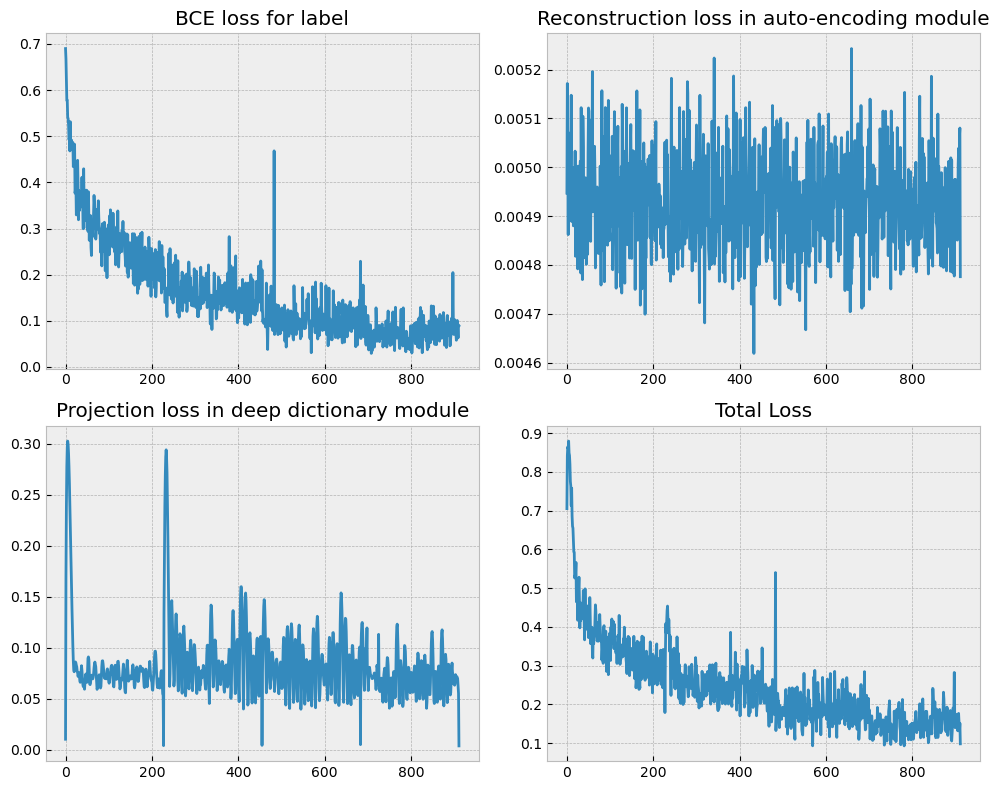

In [50]:
# Create a figure and a grid of subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

# Plot the data on each subplot
axes[0, 0].plot(loss_c)
axes[0, 0].set_title('BCE loss for label')
axes[0, 1].plot(loss_r)
axes[0, 1].set_title('Reconstruction loss in auto-encoding module')
axes[1, 0].plot(loss_p)
axes[1, 0].set_title('Projection loss in deep dictionary module')
axes[1, 1].plot(loss)
axes[1, 1].set_title('Total Loss')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

#### Evaluation on Testing Set

In [51]:
params = {'batch_size': 256,
          'shuffle': True,
          'num_workers': 6}

# Testing DDI Dataframe
labels_sup = df_ddi_test.label.values
#test_set = supData(df_ddi_test.index.values, labels_sup, df_ddi_test)
test_set = supData_index(df_ddi_test.index.values, labels_sup, df_ddi_test)
test_generator_sup = data.DataLoader(test_set, **params)

# model_nn = model_max
if not LOAD_FINAL_MODEL:
    y_pred = []
    y_label = []
    indices  = []
    model_nn.eval()

    for i, (v_D, label, idx) in tqdm(enumerate(test_generator_sup)):
        recon, code, score, Z_f, z_D = model_nn(v_D.float())
        m = torch.nn.Sigmoid()
        logits = torch.squeeze(m(score)).detach().cpu().numpy()
        label_ids = label.to('cpu').numpy()
        y_label = y_label + label_ids.flatten().tolist()
        y_pred = y_pred + logits.flatten().tolist()
        indices =  indices + idx.to('cpu').numpy().flatten().tolist()

    # Save output for visualization and reuse
    with open('temp_output/y_label.json', 'w') as file:
        json.dump(y_label, file)

    with open('temp_output/y_pred.json', 'w') as file:
        json.dump(y_pred, file)

    with open('temp_output/test_indicies.json', 'w') as file:
        json.dump(indices, file)

    test_df_pred = pd.DataFrame({'index': indices, 'y_label': y_label, 'y_pred': y_pred})
    test_df_pred.to_csv(os.path.dirname(ROOT_PATH)+'/temp_output/test_df_pred.csv', index=False)

else:
    # Use labels and predictions from previous results
    with open(os.path.dirname(ROOT_PATH)+'/temp_output/y_label.json') as f:
        y_label = json.load(f)
    with open(os.path.dirname(ROOT_PATH)+'/temp_output/y_pred.json') as f:
        y_pred = json.load(f)
    with open(os.path.dirname(ROOT_PATH)+'/temp_output/test_indicies.json') as f:
        indices = json.load(f)

    test_df_pred = pd.read_csv(os.path.dirname(ROOT_PATH)+'/temp_output/test_df_pred.csv')

In [52]:
print(test_df_pred.shape)
test_df_pred.head(10)

(16608, 3)


,index,y_label,y_pred
0,3064,0.0,3.166443e-03
1,4230,0.0,9.071952e-10
2,8478,0.0,4.980621e-04
3,9281,0.0,3.981453e-04
4,8258,0.0,1.627631e-05
5,5912,1.0,9.934123e-01
6,10064,1.0,9.913498e-01
7,4409,1.0,5.030103e-01
8,12559,1.0,4.051663e-01
9,11261,0.0,1.388017e-07


In [53]:
print("Average Precision Score:", average_precision_score(y_label, y_pred))

Average Precision Score: 0.9842349337711827


In [54]:
def DrawPrecisionRecall(y, y_pred):
  average_precision = average_precision_score(y, y_pred)
  precision, recall, _ = precision_recall_curve(y, y_pred)

  # In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
  step_kwargs = ({'step': 'post'}
                if 'step' in signature(plt.fill_between).parameters
                else {})
  plt.step(recall, precision, color='b', alpha=0.2,
          where='post')
  plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.ylim([0.0, 1.05])
  plt.xlim([0.0, 1.0])
  plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
            average_precision))

  pr_auc_score = auc(recall, precision)
  print('PR-AUC: ', pr_auc_score)

PR-AUC:  0.9842336239777925


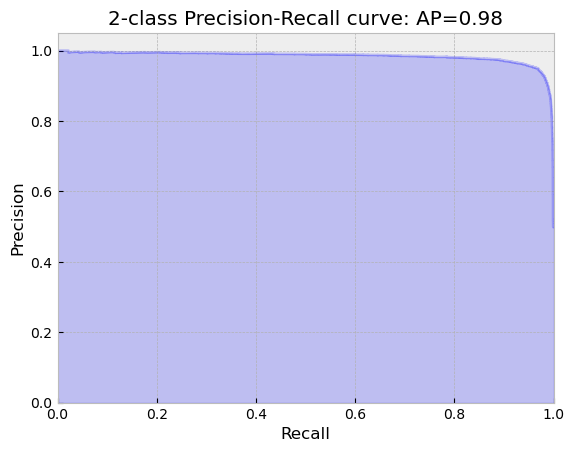

In [55]:
DrawPrecisionRecall(y_label, y_pred)

In [56]:
def DrawROC(y, y_pred):
  # ROC Curve
  fpr, tpr, thresholds = roc_curve(y, y_pred)
  auc_score = auc(fpr, tpr)

  plt.figure(1)
  plt.plot([0, 1], [0, 1], 'k--')
  plt.plot(fpr, tpr, label='Val (area = {:.3f})'.format(auc_score))
  plt.xlabel('False positive rate')
  plt.ylabel('True positive rate')
  plt.title('ROC curve')
  plt.legend(loc='best')

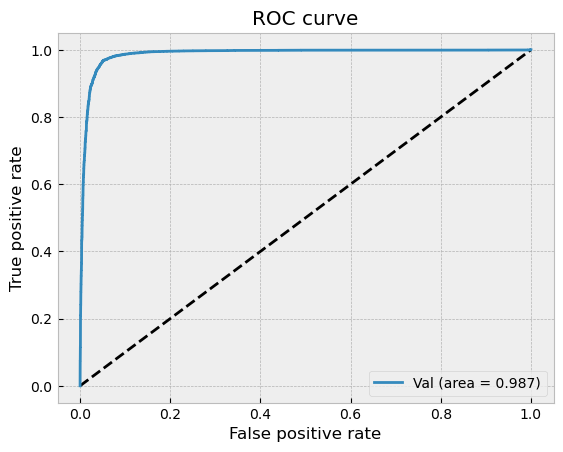

In [57]:
DrawROC(y_label, y_pred)

In [58]:
print('F1 score:', f1_score(y_label, (np.array(y_pred)>0.5)))

F1 score: 0.9585402333233622


# Results


## Hypothesis 1
*CASTER provides more accurate DDI prediction than other strong baselines.*

From the table below, we can see that the CASTER did provide more accurate DDI prediction than other baselines (statistics of other baselines were retrieved from the original paper), generating a state-of-the-art result. More specifically, we can observe that for all the three metrics, ROC-AUC, PR-AUC, and F1, CASTER has values significantly higher than other baselines.

| Model | Dataset | ROC-AUC | PR-AUC | F1 |
| --- | --- | --- | --- | --- |
| LR | BIOSNAP | 0.802 ± 0.001 | 0.779 ± 0.001 | 0.741 ± 0.002 |
| Nat.Prot | BIOSNAP | 0.853 ± 0.001 | 0.848 ± 0.001 | 0.714 ± 0.001 |
| Mol2Vec | BIOSNAP |  0.879 ± 0.006 |  0.861 ± 0.005 | 0.798 ± 0.007 |
| MolVAE | BIOSNAP |  0.892 ± 0.009 |  0.877 ± 0.009 | 0.788 ± 0.033 |
| DeepDDI | BIOSNAP |  0.886 ± 0.007 | 0.871 ± 0.007 |  0.817 ± 0.007 |
| CASTER (Original Paper) | BIOSNAP | 0.910 ± 0.005 | 0.887 ± 0.008 | 0.843 ± 0.005 |
| CASTER | BIOSNAP | **0.987** (our result) | **0.984** (our result) | **0.959** (our result) |

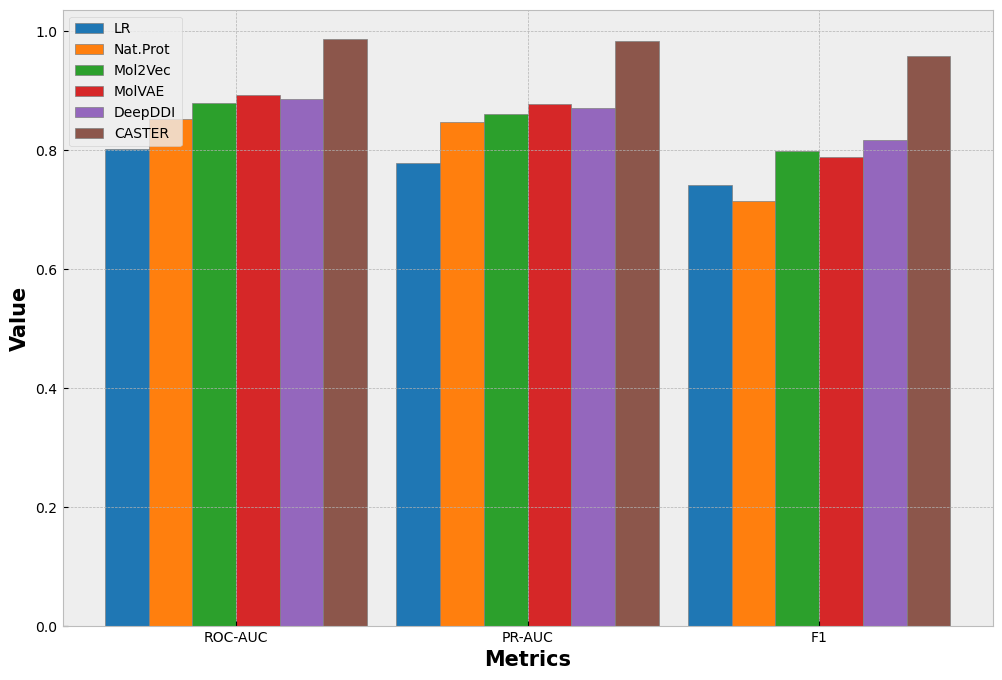

In [59]:
# Plot the numbers in the table to a bar chart
barWidth = 0.15
fig = plt.subplots(figsize =(12, 8))

LR= [0.802, 0.779, 0.741]
NatProt = [0.853, 0.848, 0.714]
Mol2Vec = [0.879, 0.861,0.798]
MolVAE = [0.892, 0.877, 0.788]
DeepDDI = [0.886, 0.871, 0.817]
CASTER = [0.987, 0.984, 0.959]

br1 = np.arange(3)
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
br4 = [x + barWidth for x in br3]
br5 = [x + barWidth for x in br4]
br6 = [x + barWidth for x in br5]

plt.bar(br1, LR, color ='tab:blue', width = barWidth,
        edgecolor ='grey', label ='LR')
plt.bar(br2, NatProt, color ='tab:orange', width = barWidth,
        edgecolor ='grey', label ='Nat.Prot')
plt.bar(br3, Mol2Vec, color ='tab:green', width = barWidth,
        edgecolor ='grey', label ='Mol2Vec')
plt.bar(br4, MolVAE, color ='tab:red', width = barWidth,
        edgecolor ='grey', label ='MolVAE')
plt.bar(br5, DeepDDI, color ='tab:purple', width = barWidth,
        edgecolor ='grey', label ='DeepDDI')
plt.bar(br6, CASTER, color ='tab:brown', width = barWidth,
        edgecolor ='grey', label ='CASTER')

# Adding Xticks
plt.xlabel('Metrics', fontweight ='bold', fontsize = 15)
plt.ylabel('Value', fontweight ='bold', fontsize = 15)
plt.xticks([r + 2.5*barWidth for r in range(3)],
        ['ROC-AUC', 'PR-AUC', 'F1'])

plt.legend()
plt.show()

## Hypothesis 2
*CASTER improves the generalizability of DDI predictions.*

For the testing dataset, all the drug pairs were unseen from the training dataset. And among them, 10974-10951=23 (from the data description) unique drugs never appeared in the training dataset. However, CASTER was able to model these unseen drugs and drug pairs successfully, reaching an average precision score of 98.5%.

To dive into the hypothesis deeper, let's conduct an experiment to compare the DDI prediction accuracies for drug pairs that contain infrequent drugs in the training data and for those that do not. To do so, we start with gathering the counts for each unique drug. Then, based on this statistics, we separate the observations in the test dataset into two groups, with or without infrequent drugs. Finally, we can compare the accuracies of the two and see if they differ from each other significantly.

In [60]:
# Gather the appearance count for each drug from the training and testing data
train_drug1 = df_ddi['Drug1_ID'].value_counts().to_frame() \
  .reset_index().rename(columns={'index': 'Drug_ID', 'Drug1_ID': 'count1'})
train_drug2 = df_ddi['Drug2_ID'].value_counts().to_frame() \
  .reset_index().rename(columns={'index': 'Drug_ID', 'Drug2_ID': 'count2'})
train_drug = pd.merge(train_drug1, train_drug2, on='Drug_ID', how='outer').fillna(0)
train_drug['train_count'] = train_drug['count1'] + train_drug['count2']
train_drug = train_drug.drop(columns=['count1', 'count2']).sort_values(by=['train_count'], ascending=False)

test_drug1 = df_ddi_test['Drug1_ID'].value_counts().to_frame() \
  .reset_index().rename(columns={'index': 'Drug_ID', 'Drug1_ID': 'count1'})
test_drug2 = df_ddi_test['Drug2_ID'].value_counts().to_frame() \
  .reset_index().rename(columns={'index': 'Drug_ID', 'Drug2_ID': 'count2'})
test_drug = pd.merge(test_drug1, test_drug2, on='Drug_ID', how='outer').fillna(0)
test_drug['test_count'] = test_drug['count1'] + test_drug['count2']
test_drug = test_drug.drop(columns=['count1', 'count2']).sort_values(by=['test_count'], ascending=False)

drug_counts = pd.merge(train_drug, test_drug, on='Drug_ID', how='outer').fillna(0)
drug_counts.head()

,Drug_ID,train_count,test_count
0,DB00252,338.0,97.0
1,DB00834,298.0,62.0
2,DB00752,281.0,59.0
3,DB00780,267.0,57.0
4,DB00715,266.0,68.0


In [61]:
# Collect infrequent drugs that appeared <=8 times in the training data
infreq_drugs = set(drug_counts[(drug_counts['train_count']<=8) & (drug_counts['test_count']>0)] \
    .reset_index()['Drug_ID'])
print('There are', len(infreq_drugs), \
      'drugs in the testing dataset that appeared in the training dataset <= 8 times.')
print(list(infreq_drugs)[:10])

There are 6063 drugs in the testing dataset that appeared in the training dataset <= 8 times.
['3703.0', '1603.0', '6836.0', '8714.0', '6590.0', '3171.0', '2950.0', '1688.0', '1283.0', '7893.0']


In [62]:
# Find the drug pairs in the test dataset that include infrequent drugs
df_ddi_test['infreq_drug'] = df_ddi_test['Drug1_ID'].isin(infreq_drugs) | df_ddi_test['Drug2_ID'].isin(infreq_drugs)
print('There are', np.sum(df_ddi_test['infreq_drug']), \
      'DDIs in the test dataset that includes infrequent drugs from the training data.')
print('Indices with infrequent drugs:', df_ddi_test[df_ddi_test['infreq_drug']].index)
df_ddi_test[['Drug1_ID', 'Drug2_ID', 'infreq_drug']].head(10)

There are 8064 DDIs in the test dataset that includes infrequent drugs from the training data.
Indices with infrequent drugs: Int64Index([    0,     1,     2,     6,     9,    11,    17,    18,    21,
               22,
            ...
            16582, 16589, 16590, 16592, 16596, 16598, 16602, 16605, 16606,
            16607],
           dtype='int64', length=8064)


,Drug1_ID,Drug2_ID,infreq_drug
0,8404.0,1503.0,True
1,DB00657,DB05245,True
2,8555.0,2262.0,True
3,3237.0,4032.0,False
4,DB01087,DB09065,False
5,DB00752,DB00887,False
6,488.0,3816.0,True
7,DB00613,DB00796,False
8,DB00607,DB09143,False
9,8612.0,6823.0,True


In [63]:
# Count the number of correct predictions for drug pairs with/witout infrequent drugs
test_df_pred['correct_pred'] = 1*(test_df_pred['y_pred'] > 0.5) == test_df_pred['y_label']
test_df_pred['infreq_drug'] = test_df_pred.index.isin(df_ddi_test[df_ddi_test['infreq_drug']].index)

print("Count of drug pairs with/without infrequent drugs:")
print(test_df_pred.groupby(['infreq_drug']).count()['correct_pred'])
print("Number of correct predictions for DDIs with/without infrequent drugs:")
print(test_df_pred.groupby(['infreq_drug']).sum()['correct_pred'])
test_df_pred.head()

Count of drug pairs with/without infrequent drugs:
infreq_drug
False    8544
True     8064
Name: correct_pred, dtype: int64
Number of correct predictions for DDIs with/without infrequent drugs:
infreq_drug
False    8185
True     7730
Name: correct_pred, dtype: int64


,index,y_label,y_pred,correct_pred,infreq_drug
0,3064,0.0,3.166443e-03,True,True
1,4230,0.0,9.071952e-10,True,True
2,8478,0.0,4.980621e-04,True,True
3,9281,0.0,3.981453e-04,True,False
4,8258,0.0,1.627631e-05,True,False


From the above, we can calculate the accuracies of DDI predictions for drug pairs with/without infrequent drugs. As shown in the below table, we can observe that the accuracies are almost the same for the two groups, indicating that the CASTER model is highly generalizable.

| Drug pair contain infrequent drugs | # of drug pairs | # of correct DDI predictions | prediction accuracy |
|---|---|---|---|
|False|8544|8185|**95.80%**|
|True|8064|7730|**95.86%**|

## Hypothesis 3
*CASTER dictionary module helps interpret its predictions.*

To validate this hypothesis, we pick one sample from the testing set, and use the deep dictionary module coefficient output to locate the most relevant substructure of the DDI prediction output.

In [64]:
sample_idx = 5

labels_sup = df_ddi_test.label.values
test_set = supData(df_ddi_test.index.values, labels_sup, df_ddi_test)

# Pick one sample
v_D_sample, y_sample = test_set[sample_idx]
print("Pick one sample from testing set: ")
print("v_D for the sample:", v_D_sample)
print("Length of v_D:", len(v_D_sample))
print("Label for the sample:", y_sample)

Pick one sample from testing set: 
v_D for the sample: [0. 0. 0. ... 0. 0. 0.]
Length of v_D: 1722
Label for the sample: 1.0


In [65]:
model_nn.eval()
v_D_sample_tensor = torch.unsqueeze(torch.tensor(v_D_sample),  dim=0)
_, code_sample, score_sample, _, _ = model_nn(v_D_sample_tensor.float())

In [66]:
# Predicted Label
m = torch.nn.Sigmoid()
logits = torch.squeeze(m(score_sample))
logits = logits.cpu().detach().numpy()
y_pred_sample = logits.flatten().tolist()[0]
print("Predicted output of the sample:", y_pred_sample)

Predicted output of the sample: 0.9955319166183472


The actual label of the sample is 1.0, indicating the interaction result is true, the predicted output is also true.

The deep dictionary module returns a list of coefficient for each frequent substructure. The code section below identifies the top K sub-structures of the chemicals/drugs contributing to the prediction, given the coefficients of the deep dictionary module as the measurement of relevance.

In [67]:
code_sample = code_sample.cpu().detach().numpy() * dde_NN_config()["magnify_factor"]
code_sample = code_sample[0]

In [68]:
# Find indices of top k values
k = 5

top_indices = np.argsort(code_sample)[-k:][::-1]

# Get top k values and their corresponding indices
top_values = code_sample[top_indices]

# Load index to substructure map
vocab_map = pd.read_csv(dataFolder + '/subword_units_map.csv')
idx2word = vocab_map['index'].values

top_words = [idx2word[i] for i in top_indices]

output = pd.DataFrame({
    "Index": top_indices,
    "Sub-structure": top_words,
    "Coefficient of Deep Dictionary Module (magnified)": top_values,
    "Rank of Relevance to Prediction": np.arange(1, len(top_indices) + 1)
})

print("Testing data recrod: ")
print(df_ddi_test.iloc[sample_idx])
print("\n")
print("Relevance output: ")
output

Testing data recrod: 
Drug1_ID                                           DB00752
Drug1_SMILES                                NC1CC1c1ccccc1
Drug2_ID                                           DB00887
Drug2_SMILES    CCCCNc1cc(C(=O)O)cc(S(N)(=O)=O)c1Oc1ccccc1
label                                                  1.0
infreq_drug                                          False
Name: 5, dtype: object


Relevance output: 


,Index,Sub-structure,Coefficient of Deep Dictionary Module (magnified),Rank of Relevance to Prediction
0,770,Nc1cc,13.359448,1
1,70,CCCC,13.035591,2
2,1208,S(N)(=O)=O),11.871164,3
3,282,c1ccccc1,9.439519,4
4,43,O,9.101594,5


From the above, we've found the top 5 substructures that are most relevant to the sample's prediction. This could provide valuable insight for researchers to interpret the DDI results.

## Extra Experiemnt

From the main results of Claim 1, we are a bit concerned about whether CASTER’s performance is closer to the paper’s original result or our replication result. Additionally, while performing data analysis for Claim 2, we figured out that almost all of the drugs (10951 out of 10974) appeared in both training and test sets, which could lead to an overestimation of CASTER’s performance. To investigate these issues, we design an experiment that regroups the training and test data, enforcing that each drug pair in the test set contains at least one drug unseen in the training set. We believe that this extra study could provide insight into the performance of CASTER in scenarios where new drugs are involved, and the results of this experiment could also serve as a lower bound to the performance of CASTER.

The drug pair observations are divided into either training or test datasets according to the following procedure. First, we combine all the data from the training and test set into one dataset. Then, out of the 10974 distinct drugs in the combined dataset, we randomly selected 10% of them, which are 1097 drugs, that could only appear in the testing dataset. Therefore, we picked all the drug pairs containing at least one of these 1097 drugs into the test set. Finally, the rest of the drug pairs stayed in the training set. As a result, there are 16032 drug pairs in the test set and 67008 pairs in the training set, both of which have similar data sizes compared to the original datasets (16608 and 66432).


In [44]:
if __name__ == "__main__":
    if not LOAD_FINAL_MODEL:
        model_exp1, loss_c_exp1, loss_r_exp1, loss_p_exp1, loss_exp1 = main_dde_nn(study = "experiment1")
    pass

In [45]:
if not LOAD_FINAL_MODEL:
    # Save output for visualization and reuse
    loss_c_exp1 = torch.tensor(loss_c_exp1).cpu().tolist()
    loss_r_exp1 = torch.tensor(loss_r_exp1).cpu().tolist()
    loss_p_exp1 = torch.tensor(loss_p_exp1).cpu().tolist()
    loss_exp1 = torch.tensor(loss_exp1).cpu().tolist()

    training_loss_exp1 = {
        "loss_c": loss_c_exp1,
        "loss_r": loss_r_exp1,
        "loss_p": loss_p_exp1,
        "loss": loss_exp1
    }

    with open('temp_output/training_loss_experiment1.json', 'w') as file:
        json.dump(training_loss_exp1, file)
else:
    # Read training losses from previous results
    with open(os.path.dirname(ROOT_PATH)+'/temp_output/training_loss_experiment1.json') as f:
        training_loss_exp1 = json.load(f)

    loss_c_exp1 = training_loss_exp1['loss_c']
    loss_r_exp1 = training_loss_exp1['loss_r']
    loss_p_exp1 = training_loss_exp1['loss_p']
    loss_exp1 = training_loss_exp1['loss']

In [46]:
if LOAD_FINAL_MODEL:
    path = (
        os.path.dirname(ROOT_PATH)
        + "/model_train_checkpoint_SNAP_EarlyStopping_SemiSup_Full_Run3_20240428_0041_experiment1.pt"
    )
    model_exp1 = load_model_from_path(path)
else:
    pass

### Evaluation of Experiment 1

In [47]:
params = {'batch_size': 256,
          'shuffle': True,
          'num_workers': 6}

# Testing DDI Dataframe
labels_sup_exp1 = df_ddi_exp1_test.label.values
test_set_exp1 = supData_index(df_ddi_exp1_test.index.values, labels_sup_exp1, df_ddi_exp1_test)
test_generator_sup_exp1 = data.DataLoader(test_set_exp1, **params)

if not LOAD_FINAL_MODEL:
    y_pred_exp1 = []
    y_label_exp1 = []
    indices_exp1  = []
    model_exp1.eval()

    for i, (v_D, label, idx) in tqdm(enumerate(test_generator_sup_exp1)):
        recon, code, score, Z_f, z_D = model_exp1(v_D.float())
        m = torch.nn.Sigmoid()
        logits = torch.squeeze(m(score)).detach().cpu().numpy()
        label_ids = label.to('cpu').numpy()
        y_label_exp1 = y_label_exp1 + label_ids.flatten().tolist()
        y_pred_exp1 = y_pred_exp1 + logits.flatten().tolist()
        indices_exp1 =  indices_exp1 + idx.to('cpu').numpy().flatten().tolist()

    # Save output for visualization and reuse
    with open('temp_output/y_label_exp1.json', 'w') as file:
        json.dump(y_label_exp1, file)

    with open('temp_output/y_pred_exp1.json', 'w') as file:
        json.dump(y_pred_exp1, file)

    with open('temp_output/test_indicies_exp1.json', 'w') as file:
        json.dump(indices_exp1, file)

    test_df_pred_exp1 = pd.DataFrame({'index': indices_exp1, 'y_label': y_label_exp1, 'y_pred': y_pred_exp1})
    test_df_pred_exp1.to_csv('temp_output/test_df_pred_exp1.csv', index=False)
else:
    # Use labels and predictions from previous results
    with open(os.path.dirname(ROOT_PATH)+'/temp_output/y_label_exp1.json') as f:
        y_label_exp1 = json.load(f)

    with open(os.path.dirname(ROOT_PATH)+'/temp_output/y_pred_exp1.json') as f:
        y_pred_exp1 = json.load(f)

    with open(os.path.dirname(ROOT_PATH)+'/temp_output/test_indicies_exp1.json') as f:
        indices = json.load(f)


In [48]:
print("Average Precision Score:", average_precision_score(y_label_exp1, y_pred_exp1))

Average Precision Score: 0.8734456781802598


In [49]:
print(len(y_label_exp1))
print(len(y_pred_exp1))

16032
16032


PR-AUC:  0.8734117305485382


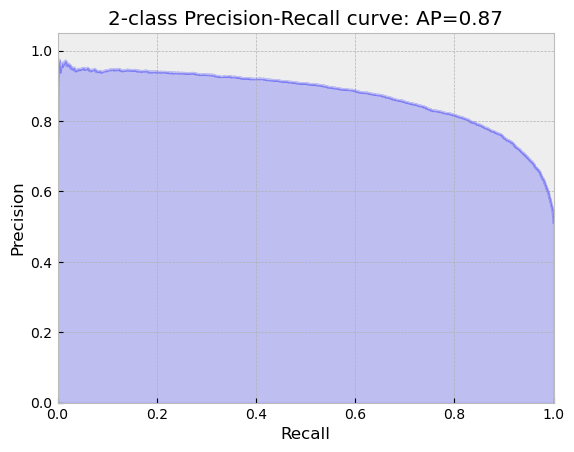

In [50]:
DrawPrecisionRecall(y_label_exp1, y_pred_exp1)

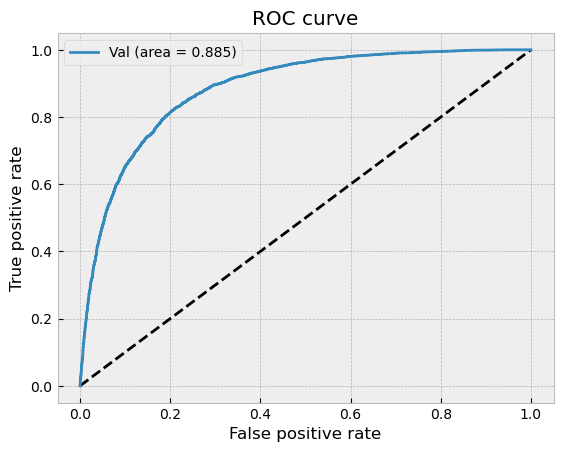

In [51]:
DrawROC(y_label_exp1, y_pred_exp1)

In [52]:
print('F1 score:', f1_score(y_label_exp1, (np.array(y_pred_exp1)>0.5)))

F1 score: 0.7038291605301915


## Albations

In the deep dictionary module, CASTER first generates a functional representation for each frequent sub-structure $C_i \in C$ as a single-hot vector $u_i = [u_i^{(1)}...u_i^{(k)}]$.

CASTER then expoits the above encoder to generate a matrix $B= = [b_1,b_2,...,b_k]$ of latent feature vectors for $U = {u_1,...,u_k}$ such that $$b_i = W_eu_i+b_e$$

Likewise, each functional representation $x$ of any drug-drug pair can also be first translated into a latent feature vector $z$ using the same encoder. The resulting latent vector $z$ can then be projected on a sub-space defined by $span(B)$ for which $z \simeq b_1r_1 + ... + b_kr_k$, where $r = [r_1 r_2 ... r_k]$ is a column vector of projection coefficients. Combining the loss of projecting coefficients to the subspace and the penalty of the complexity of the encoder basis subspace, we come up with an augmented loss function

$$
L_p(W_e, b_e, r) = (\frac{1}{2}{\|z-B^Tr\|}_2^2+\lambda_1{\|r\|_2}) + \lambda_2{\|B\|_F^2}
$$

### Ablation 1: L2-regularization on the span of projection vector

In the loss function above, $\lambda_1$ is a regularization parameter controls the complexity of the projection ${\|r\|_2}$.

In ablation study 1, we remove the panelty on this term by setting $\lambda_1 = 0$.


In [53]:
if __name__ == "__main__":
    if not LOAD_FINAL_MODEL:
        model_ablation1, loss_c_ablation1, loss_r_ablation1, loss_p_ablation1, loss_ablation1 = main_dde_nn(study = "ablation1")
    pass

In [54]:
if not LOAD_FINAL_MODEL:
    # Save output for visualization and reuse
    loss_c_ablation1 = torch.tensor(loss_c_ablation1).cpu().tolist()
    loss_r_ablation1 = torch.tensor(loss_r_ablation1).cpu().tolist()
    loss_p_ablation1 = torch.tensor(loss_p_ablation1).cpu().tolist()
    loss_ablation1 = torch.tensor(loss_ablation1).cpu().tolist()

    training_loss_ablation1 = {
        "loss_c": loss_c_ablation1,
        "loss_r": loss_r_ablation1,
        "loss_p": loss_p_ablation1,
        "loss": loss_ablation1
    }

    with open('temp_output/training_loss_ablation1.json', 'w') as file:
        json.dump(training_loss_ablation1, file)
else:
    # Read training losses from previous results
    with open(os.path.dirname(ROOT_PATH)+'/temp_output/training_loss_ablation1.json') as f:
        training_loss_ablation1 = json.load(f)

    loss_c_ablation1 = training_loss_ablation1['loss_c']
    loss_r_ablation1 = training_loss_ablation1['loss_r']
    loss_p_ablation1 = training_loss_ablation1['loss_p']
    loss_ablation1 = training_loss_ablation1['loss']

In [55]:
if LOAD_FINAL_MODEL:
    path = (
        os.path.dirname(ROOT_PATH)
        + "/model_train_checkpoint_SNAP_EarlyStopping_SemiSup_Full_Run3_20240424_0406_ablation1.pt"
    )
    model_ablation1 = load_model_from_path(path)
else:
    pass

### Evaluation of Ablation 1

In [56]:
params = {'batch_size': 256,
          'shuffle': True,
          'num_workers': 6}

# Testing DDI Dataframe
labels_sup = df_ddi_test.label.values
#test_set = supData(df_ddi_test.index.values, labels_sup, df_ddi_test)
test_set = supData_index(df_ddi_test.index.values, labels_sup, df_ddi_test)
test_generator_sup = data.DataLoader(test_set, **params)

if not LOAD_FINAL_MODEL:
    y_pred_ab1 = []
    y_label_ab1 = []
    indices_ab1  = []
    model_ablation1.eval()

    for i, (v_D, label, idx) in tqdm(enumerate(test_generator_sup)):
        recon, code, score, Z_f, z_D = model_ablation1(v_D.float())
        m = torch.nn.Sigmoid()
        logits = torch.squeeze(m(score)).detach().cpu().numpy()
        label_ids = label.to('cpu').numpy()
        y_label_ab1 = y_label_ab1 + label_ids.flatten().tolist()
        y_pred_ab1 = y_pred_ab1 + logits.flatten().tolist()
        indices_ab1 =  indices_ab1 + idx.to('cpu').numpy().flatten().tolist()

    # Save output for visualization and reuse
    with open('temp_output/y_label_ab1.json', 'w') as file:
        json.dump(y_label_ab1, file)

    with open('temp_output/y_pred_ab1.json', 'w') as file:
        json.dump(y_pred_ab1, file)

    with open('temp_output/test_indicies_ab1.json', 'w') as file:
        json.dump(indices_ab1, file)

    test_df_pred_ab1 = pd.DataFrame({'index': indices_ab1, 'y_label': y_label_ab1, 'y_pred': y_pred_ab1})
    test_df_pred_ab1.to_csv(os.path.dirname(ROOT_PATH)+'/temp_output/test_df_pred_ab1.csv', index=False)

else:
    # Use labels and predictions from previous results
    with open(os.path.dirname(ROOT_PATH)+'/temp_output/y_label_ab1.json') as f:
        y_label_ab1 = json.load(f)

    with open(os.path.dirname(ROOT_PATH)+'/temp_output/y_pred_ab1.json') as f:
        y_pred_ab1 = json.load(f)

    with open(os.path.dirname(ROOT_PATH)+'/temp_output/test_indicies_ab1.json') as f:
        indices_ab1 = json.load(f)

    test_df_pred_ab1 = pd.read_csv(os.path.dirname(ROOT_PATH)+'/temp_output/test_df_pred_ab1.csv')

In [57]:
print("Average Precision Score:", average_precision_score(y_label_ab1, y_pred_ab1))

Average Precision Score: 0.9847120811892284


PR-AUC:  0.9847104116445264


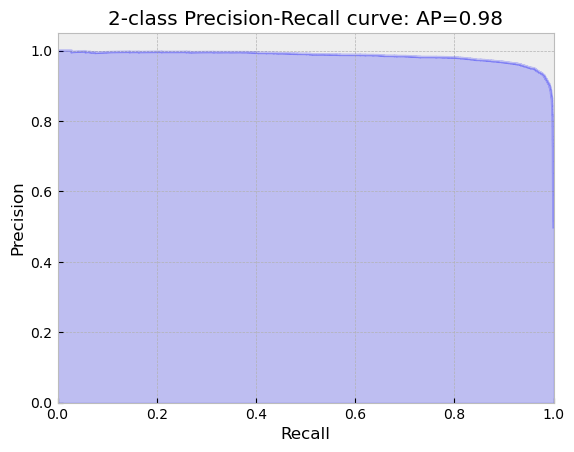

In [58]:
DrawPrecisionRecall(y_label_ab1, y_pred_ab1)

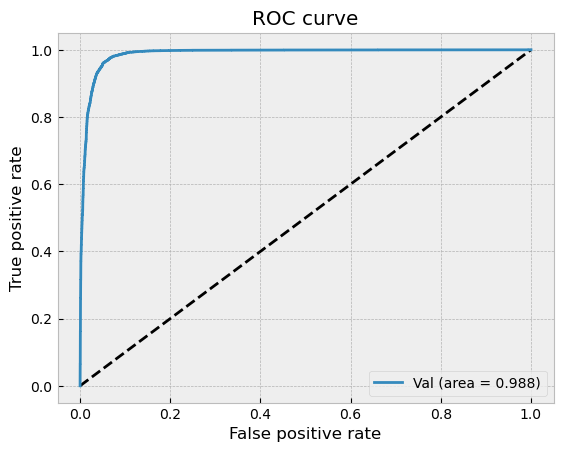

In [59]:
DrawROC(y_label_ab1, y_pred_ab1)

In [60]:
print('F1 score:', f1_score(y_label_ab1, (np.array(y_pred_ab1)>0.5)))

F1 score: 0.9500515870607513


### Ablation 2: Penalty of Frobenius norm on the latent feature vector space of frequent substructures

In the loss function below, $\lambda_2$ is the parameter for the panelty of the dimension/complexity of the hidden size of the second layer of the encoder module.
$$
L_p(W_e, b_e, r) = (\frac{1}{2}{\|z-B^Tr\|}_2^2+\lambda_1{\|r\|_2}) + \lambda_2{\|B\|_F^2}
$$

Mathematically it calculates the [Frobenius norm](https://mathworld.wolfram.com/FrobeniusNorm.html#:~:text=The%20Frobenius%20norm%2C%20sometimes%20also,considered%20as%20a%20vector%20norm.) of matrix $B$ (```Z_f``` in the script).

In ablation study 2, we remove the panelty on this term by setting $\lambda_2 = 0$.


In [61]:
if __name__ == "__main__":
    if not LOAD_FINAL_MODEL:
        model_ablation2, loss_c_ablation2, loss_r_ablation2, loss_p_ablation2, loss_ablation2 = main_dde_nn(study = "ablation2")
    pass

In [62]:
if not LOAD_FINAL_MODEL:
    # Save output for visualization and reuse
    loss_c_ablation2 = torch.tensor(loss_c_ablation2).cpu().tolist()
    loss_r_ablation2 = torch.tensor(loss_r_ablation2).cpu().tolist()
    loss_p_ablation2 = torch.tensor(loss_p_ablation2).cpu().tolist()
    loss_ablation2 = torch.tensor(loss_ablation2).cpu().tolist()

    training_loss_ablation2 = {
        "loss_c": loss_c_ablation2,
        "loss_r": loss_r_ablation2,
        "loss_p": loss_p_ablation2,
        "loss": loss_ablation2
    }

    with open('temp_output/training_loss_ablation2.json', 'w') as file:
        json.dump(training_loss_ablation1, file)
else:
    # Read training losses from previous results
    with open(os.path.dirname(ROOT_PATH)+'/temp_output/training_loss_ablation2.json') as f:
        training_loss_ablation2 = json.load(f)

        loss_c_ablation2 = training_loss_ablation2['loss_c']
        loss_r_ablation2 = training_loss_ablation2['loss_r']
        loss_p_ablation2 = training_loss_ablation2['loss_p']
        loss_ablation2 = training_loss_ablation2['loss']

In [63]:
if LOAD_FINAL_MODEL:
    path = (
        os.path.dirname(ROOT_PATH)
        + "/model_train_checkpoint_SNAP_EarlyStopping_SemiSup_Full_Run3_20240424_0504_ablation2.pt"
    )
    model_ablation2 = load_model_from_path(path)
else:
    pass

### Evaluation of Ablation 2

In [64]:
params = {'batch_size': 256,
          'shuffle': True,
          'num_workers': 6}

# Testing DDI Dataframe
labels_sup = df_ddi_test.label.values
#test_set = supData(df_ddi_test.index.values, labels_sup, df_ddi_test)
test_set = supData_index(df_ddi_test.index.values, labels_sup, df_ddi_test)
test_generator_sup = data.DataLoader(test_set, **params)

if not LOAD_FINAL_MODEL:
    y_pred_ab2 = []
    y_label_ab2 = []
    indices_ab2  = []
    model_ablation2.eval()

    for i, (v_D, label, idx) in tqdm(enumerate(test_generator_sup)):
        recon, code, score, Z_f, z_D = model_ablation2(v_D.float())
        m = torch.nn.Sigmoid()
        logits = torch.squeeze(m(score)).detach().cpu().numpy()
        label_ids = label.to('cpu').numpy()
        y_label_ab2 = y_label_ab2 + label_ids.flatten().tolist()
        y_pred_ab2 = y_pred_ab2 + logits.flatten().tolist()
        indices_ab2 =  indices_ab2 + idx.to('cpu').numpy().flatten().tolist()

    # Save output for visualization and reuse
    with open('temp_output/y_label_ab2.json', 'w') as file:
        json.dump(y_label_ab2, file)

    with open('temp_output/y_pred_ab2.json', 'w') as file:
        json.dump(y_pred_ab2, file)

    with open('temp_output/test_indicies_ab2.json', 'w') as file:
        json.dump(indices_ab2, file)

    test_df_pred_ab2 = pd.DataFrame({'index': indices_ab2, 'y_label': y_label_ab2, 'y_pred': y_pred_ab2})
    test_df_pred_ab2.to_csv(os.path.dirname(ROOT_PATH)+'/temp_output/test_df_pred_ab2.csv', index=False)

else:
    # Use labels and predictions from previous results
    with open(os.path.dirname(ROOT_PATH)+'/temp_output/y_label_ab2.json') as f:
        y_label_ab2 = json.load(f)

    with open(os.path.dirname(ROOT_PATH)+'/temp_output/y_pred_ab2.json') as f:
        y_pred_ab2 = json.load(f)

    with open(os.path.dirname(ROOT_PATH)+'/temp_output/test_indicies_ab2.json') as f:
        indices_ab2 = json.load(f)

    test_df_pred_ab2 = pd.read_csv(os.path.dirname(ROOT_PATH)+'/temp_output/test_df_pred_ab2.csv')

In [65]:
print("Average Precision Score:", average_precision_score(y_label_ab2, y_pred_ab2))

Average Precision Score: 0.9854786608576241


PR-AUC:  0.9854769134666219


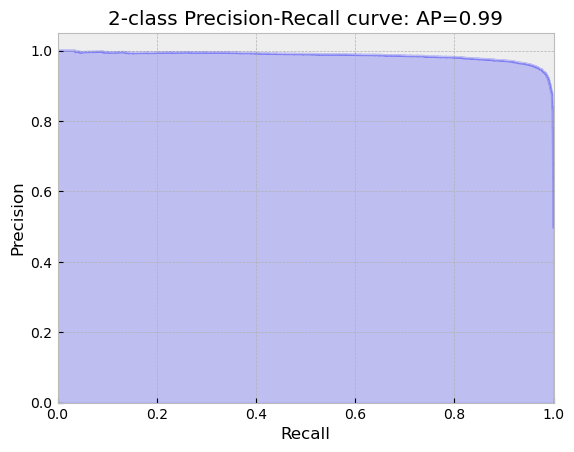

In [66]:
DrawPrecisionRecall(y_label_ab2, y_pred_ab2)

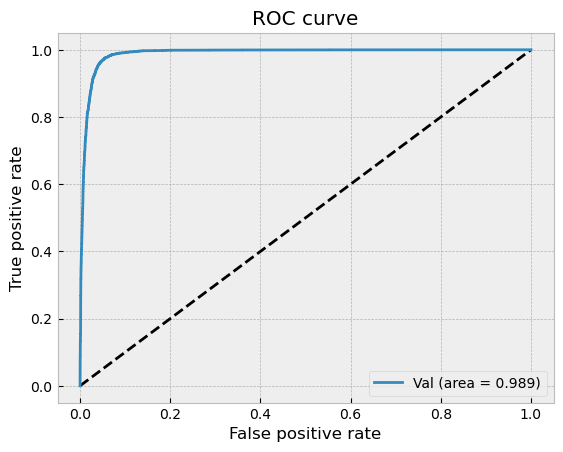

In [67]:
DrawROC(y_label_ab2, y_pred_ab2)

In [68]:
print('F1 score:', f1_score(y_label_ab2, (np.array(y_pred_ab2)>0.5)))

F1 score: 0.9594842372981606


## Discussion

### Main Result

#### Claim 1: CASTER provides more accurate DDI prediction than other strong baselines.

We are able to reproduce this claim, with the CASTER framework having significantly higher accuracies in DDI predictions compared to other strong baselines. In fact, our results are even better than the results claimed by the authors (see the last two rows of the table). Since we used the authors’ GitHub repository for replication, this gap could have originated from dataset differences or model refinements after the publication of the paper.

#### Claim 2: CASTER improves the generalizability of DDI predictions.

From the original paper, this claim is validated by the ability of CASTER to decompose any chemical structure into substructures and embed them into a latent space. However, little is addressed about the actual performance of DDI predictions on drugs that are rarely seen in the training dataset. To further evaluate this claim according to this metric, we separate the observations in the test dataset into two groups based on whether each drug pair contains infrequent drugs (appeared <=8 times in the training dataset) or not. We find that the prediction accuracies of the two groups are similar, indicating that the CASTER model is generalizable to rarely seen drugs.

#### Claim 3: CASTER dictionary module helps interpret its predictions.

CASTER dictionary module is able to returns a list of coefficient for each frequent substructure. The coefficients can be interpreted as sub-structures of the chemicals/drugs contributing to the prediction, given the coefficients of the deep dictionary module as the measurement of relevance.

### Extra Experiment & Ablations
|Model                  |Dataset|ROC-AUC|PR-AUC|F1   |
|-----------------------|-------|-------|------|-----|
|CASTER (Original Paper)| BIOSNAP | 0.910 ± 0.005 | 0.887 ± 0.008 | 0.843 ± 0.005 |
|CASTER| BIOSNAP| **0.987** (our result) | **0.984** (our result) | **0.959** (our result) |
|Extra Experiment 1     |BIOSNAP|0.885  |0.873 |0.704|
|Ablation 1             |BIOSNAP|0.988  |0.984 |0.950|
|Ablation 2             |BIOSNAP|0.989  |0.985 |0.959|

The result of this extra study shows that the average precision score goes down from 98.4% to 87.3%, ROC-AUC goes down from 98.7% to 88.5%, and F1 score goes down from 0.959 to 0.704. This indicates that while CASTER retains prediction power on drug or food chemicals that are never seen in the training set, the performance would be inferior compared to chemicals that it has seen before. This lower bound of CASTER’s predictive ability may also help explain the performance gap between the authors’ and our results in Claim 1.

The first ablation study removes the term in the loss function that regulates the span of projection vector. The second ablation function removes the term in the loss function that penalize the dimension of the latent feature vector space. With the current hyper parameter setup, it does not introduce significant difference compared with the original model. We see close numbers with the metrics of PR-AUC, ROC-AUC and F1.

### What Was Easy

The code in this notebook/Github repo incorporates original code sourced from the GitHub repository: https://github.com/kexinhuang12345/CASTER/tree/master, which is published by the author of the original paper. The source code is readable and relatively easy to reproduce with very few minor bugs.

### What Was Difficult

In this project, we trained four models in total: original CASTER model, extra experiment and models for two ablation studies. The training process was implemented in the Amazon SageMaker notebook ml.p3.8xlarge instance, with the [cost of $14.688 per hour](https://aws.amazon.com/sagemaker/pricing/). Given the limited resources, we were not able to compare the model performance under different hyper parameters. For example, in two ablation studies we did not see much performance difference between the ablation models and the original model. We think it is because the coefficients associated with two different regularization terms in the original model are not significant enough to impact the model performance. Besides, due to the constraints on both time and resources, we were unable to fine tune the model with different sets of hyper parameters, including batch size, learning rate, hidden size, etc.

### Recommendations

The Github repository from the original author does not distinguish the action of training the model with loading model from a file. In this notebook, we introduce a parameter ```LOAD_FINAL_MODEL``` to control different scenarios. When loading models from existing files from the repository, we set the parameter to TRUE. When we need to train the models, we set the parameters to FALSE.

<h1>References</h1>
[Huang et al. 2020] Huang, K., Xiao, C., Hoang, T., Glass, L., & Sun, J. (2020). CASTER: Predicting Drug Interactions with Substructure Representation. AAAI.
